In [1]:
%reset -fs
import pandas as pd
import  numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
from dask import dataframe as dd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.options.mode.use_inf_as_na = True
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [2]:
ddf = dd.read_csv(r"C:\Users\nated\Downloads\CSV-01-12\01-12\DrDoS_LDAP.csv", dtype={'SimillarHTTP': 'object'},blocksize='64MB')
df = ddf.compute()

In [3]:
df.columns = df.columns.str.replace(' ', '')

In [4]:
(df['Label'].value_counts()) / len(df) * 100

DrDoS_LDAP    99.926107
BENIGN         0.073893
Name: Label, dtype: float64

In [5]:
df.drop(columns=['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp', 'SimillarHTTP', 'SourcePort', 'DestinationPort'], inplace=True)

In [6]:
df.dropna(inplace=True)

In [7]:
cols = df.drop(columns=['Label']).columns.tolist()
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

In [8]:
labels = pd.get_dummies(df['Label'])

In [9]:
X = df.drop(columns=["Label"], axis=1)
y = labels.BENIGN

In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000000, n_jobs=-1)

In [11]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=1)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, stratify=y_train_val, random_state=1)

In [13]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [14]:
X_train_scaled = pd.DataFrame(
    std.fit_transform(X_train),
    columns = X_train.columns)

In [15]:
import joblib
from dask.distributed import Client

client = Client(processes=False)

In [16]:
with joblib.parallel_backend("dask"):
    lr.fit(X_train_scaled, y_train)
    

In [17]:
X_val_scaled = pd.DataFrame(std.transform(X_val), columns = X_val.columns)

In [18]:
y_val_preds = lr.predict(X_val_scaled)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.91875, Recall: 0.9216300940438872, F2 Score: 0.9210526315789475


In [19]:
lr_confusion = confusion_matrix(y_val, y_val_preds)

In [20]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in lr_confusion.flatten()/np.sum(lr_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

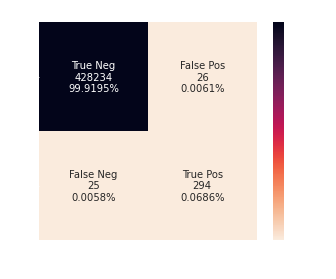

In [21]:
sns.heatmap(lr_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Logistic Regression Confusion Matrix');

Logistic Regression Model best F Beta2 score 0.959 at prob decision threshold >= 0.030
Logistic Regression Model best recall score 0.991 at prob decision threshold >= 0.010
Logistic Regression Model best precision score 0.991 at prob decision threshold >= 0.990


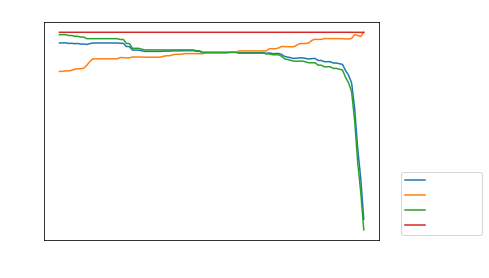

In [22]:
thresh_ps = np.linspace(0.01,0.99,101)
model_val_probs = lr.predict_proba(X_val_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

fbeta_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=2))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, fbeta_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F Beta 2','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_fbeta_score = np.max(fbeta_scores) 
best_thresh_p_fbeta = thresh_ps[np.argmax(fbeta_scores)]
best_recall_score = np.max(rec_scores)
best_thresh_p_rec = thresh_ps[np.argmax(rec_scores)]
best_prec_score = np.max(prec_scores)
best_thresh_p_prec = thresh_ps[np.argmax(prec_scores)]

print('Logistic Regression Model best F Beta2 score %.3f at prob decision threshold >= %.3f' 
      % (best_fbeta_score, best_thresh_p_fbeta))
print('Logistic Regression Model best recall score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_rec))
print('Logistic Regression Model best precision score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_prec))

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=2)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=2)

In [25]:
X_train_scaled = pd.DataFrame(
    std.fit_transform(X_train),
    columns = X_train.columns)

In [26]:
lr2 = LogisticRegression(solver='lbfgs', max_iter=1000000, n_jobs=-1, class_weight='balanced')

In [27]:
with joblib.parallel_backend("dask"):
    lr2.fit(X_train_scaled, y_train)

In [28]:
X_val_scaled = pd.DataFrame(std.transform(X_val), columns = X_val.columns)

In [29]:
y_val_preds = lr2.predict(X_val_scaled)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.8315789473684211, Recall: 0.9905956112852664, F2 Score: 0.9541062801932366


In [30]:
lr2_confusion = confusion_matrix(y_val, y_val_preds)

In [31]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in lr2_confusion.flatten()/np.sum(lr2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

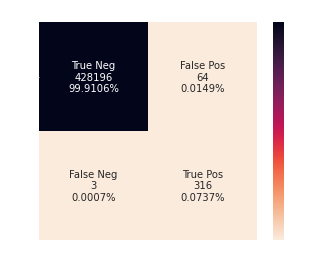

In [32]:
sns.heatmap(lr2_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Weighted Logistic Regression Confusion Matrix');

Balanced Logistic Regression Model best F Beta2 score 0.965 at prob decision threshold >= 0.990
Balanced Logistic Regression Model best recall score 0.991 at prob decision threshold >= 0.010
Balanced Logistic Regression Model best precision score 0.991 at prob decision threshold >= 0.990


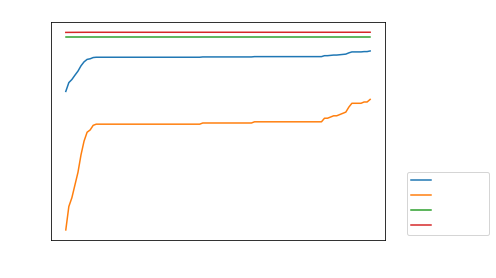

In [33]:
thresh_ps = np.linspace(0.01,0.99,101)
model_val_probs = lr2.predict_proba(X_val_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

fbeta_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=2))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, fbeta_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F Beta 2','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_fbeta_score = np.max(fbeta_scores) 
best_thresh_p_fbeta = thresh_ps[np.argmax(fbeta_scores)]
best_recall_score = np.max(rec_scores)
best_thresh_p_rec = thresh_ps[np.argmax(rec_scores)]
best_prec_score = np.max(prec_scores)
best_thresh_p_prec = thresh_ps[np.argmax(prec_scores)]

print('Balanced Logistic Regression Model best F Beta2 score %.3f at prob decision threshold >= %.3f' 
      % (best_fbeta_score, best_thresh_p_fbeta))
print('Balanced Logistic Regression Model best recall score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_rec))
print('Balanced Logistic Regression Model best precision score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_prec))

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=3)

In [35]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=3)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=3)

In [37]:
with joblib.parallel_backend("dask"):
    rf.fit(X_train, y_train)

In [38]:
y_val_preds = rf.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9905956112852664, Recall: 0.9905956112852664, F2 Score: 0.9905956112852664


In [39]:
rf_confusion = confusion_matrix(y_val, y_val_preds)

In [40]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf_confusion.flatten()/np.sum(rf_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

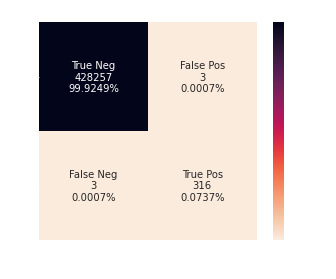

In [41]:
sns.heatmap(rf_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest Confusion Matrix');

In [42]:
rf2 = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=4, class_weight='balanced')

In [43]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=4)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=4)

In [45]:
with joblib.parallel_backend("dask"):
    rf2.fit(X_train, y_train)

In [46]:
y_val_preds = rf2.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9904458598726115, Recall: 0.9749216300940439, F2 Score: 0.9779874213836476


In [47]:
rf2_confusion = confusion_matrix(y_val, y_val_preds)

In [48]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf2_confusion.flatten()/np.sum(rf2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

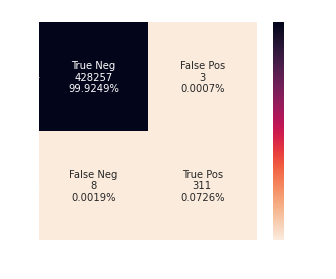

In [49]:
sns.heatmap(rf2_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Weighted Random Forest Confusion Matrix');

In [50]:
rf3 = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=5, class_weight='balanced_subsample')

In [51]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=5)

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=5)

In [53]:
with joblib.parallel_backend("dask"):
    rf3.fit(X_train, y_train)

In [54]:
y_val_preds = rf3.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9874213836477987, Recall: 0.9843260188087775, F2 Score: 0.9849435382685069


In [55]:
rf3_confusion = confusion_matrix(y_val, y_val_preds)

In [56]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf3_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf3_confusion.flatten()/np.sum(rf3_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

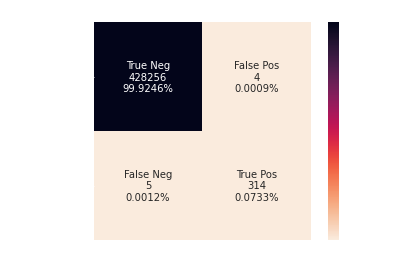

In [57]:
sns.heatmap(rf3_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest With Bootstrap Class Weighting Confusion Matrix');

In [58]:
imb_rf = BalancedRandomForestClassifier(n_estimators=1000, random_state=6, n_jobs=-1)

In [59]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=6)

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=6)

In [61]:
with joblib.parallel_backend("dask"):
    imb_rf.fit(X_train, y_train)

In [62]:
y_val_preds = imb_rf.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.5186991869918699, Recall: 1.0, F2 Score: 0.8434690639873083


In [63]:
imb_rf_confusion = confusion_matrix(y_val, y_val_preds)

In [64]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf_confusion.flatten()/np.sum(imb_rf_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

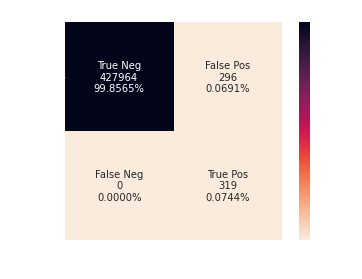

In [65]:
sns.heatmap(imb_rf_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling Confusion Matrix');

In [66]:
imb_rf2 = BalancedRandomForestClassifier(n_estimators=1000, random_state=7, class_weight='balanced', n_jobs=-1)

In [67]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=7)

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=7)

In [69]:
with joblib.parallel_backend("dask"):
    imb_rf2.fit(X_train, y_train)

In [70]:
y_val_preds = imb_rf2.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.5462328767123288, Recall: 1.0, F2 Score: 0.8575268817204301


In [71]:
imb_rf2_confusion = confusion_matrix(y_val, y_val_preds)

In [72]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf2_confusion.flatten()/np.sum(imb_rf2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

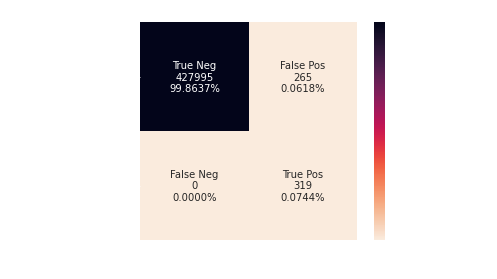

In [73]:
sns.heatmap(imb_rf2_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling (Balanced Class Weight) Confusion Matrix');

In [74]:
imb_rf3 = BalancedRandomForestClassifier(n_estimators=1000, random_state=8, class_weight='balanced_subsample', n_jobs=-1)

In [75]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=8)

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=8)

In [77]:
with joblib.parallel_backend("dask"):
    imb_rf3.fit(X_train, y_train)

In [78]:
y_val_preds = imb_rf3.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.5747747747747748, Recall: 1.0, F2 Score: 0.8711086837793555


In [79]:
imb_rf3_confusion = confusion_matrix(y_val, y_val_preds)

In [80]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf3_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf3_confusion.flatten()/np.sum(imb_rf3_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

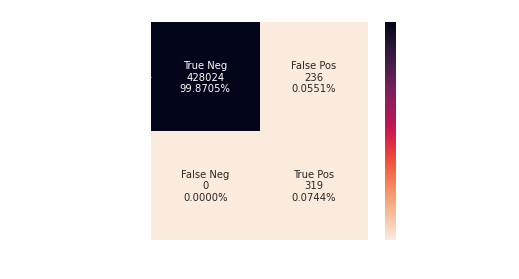

In [81]:
sns.heatmap(imb_rf3_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling (Bootstrap Class Weighting) Confusion Matrix');

In [82]:
gbm = xgb.XGBClassifier(
                        n_estimators=100000,
                        max_depth=6,
                        objective="binary:logistic",
                        learning_rate=.1,
                        subsample=1,
                        scale_pos_weight=99,
                        min_child_weight=1,
                        colsample_bytree=1,
                        tree_method='gpu_hist',
                        use_label_encoder=False
                        )

In [83]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=9)

In [84]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=9)

In [85]:
eval_set=[(X_train,y_train),(X_val,y_val)] 
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True 
                   )

[0]	validation_0-auc:0.99999	validation_1-auc:0.99999
[1]	validation_0-auc:0.99999	validation_1-auc:0.99999
[2]	validation_0-auc:1.00000	validation_1-auc:1.00000
[3]	validation_0-auc:1.00000	validation_1-auc:1.00000
[4]	validation_0-auc:1.00000	validation_1-auc:1.00000
[5]	validation_0-auc:1.00000	validation_1-auc:1.00000
[6]	validation_0-auc:1.00000	validation_1-auc:1.00000
[7]	validation_0-auc:1.00000	validation_1-auc:1.00000
[8]	validation_0-auc:1.00000	validation_1-auc:1.00000
[9]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10]	validation_0-auc:1.00000	validation_1-auc:1.00000
[11]	validation_0-auc:1.00000	validation_1-auc:1.00000
[12]	validation_0-auc:1.00000	validation_1-auc:1.00000
[13]	validation_0-auc:1.00000	validation_1-auc:1.00000
[14]	validation_0-auc:1.00000	validation_1-auc:1.00000
[15]	validation_0-auc:1.00000	validation_1-auc:1.00000
[16]	validation_0-auc:1.00000	validation_1-auc:1.00000
[17]	validation_0-auc:1.00000	validation_1-auc:1.00000
[18]	validation_0-au

In [86]:
y_val_preds = gbm.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9464285714285714, Recall: 0.9968652037617555, F2 Score: 0.9863523573200992


In [87]:
gbm_confusion = confusion_matrix(y_val, y_val_preds)

In [88]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in gbm_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in gbm_confusion.flatten()/np.sum(gbm_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

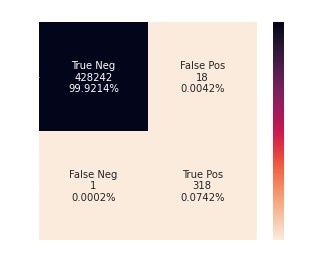

In [89]:
sns.heatmap(gbm_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('XGBoost Confusion Matrix');

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

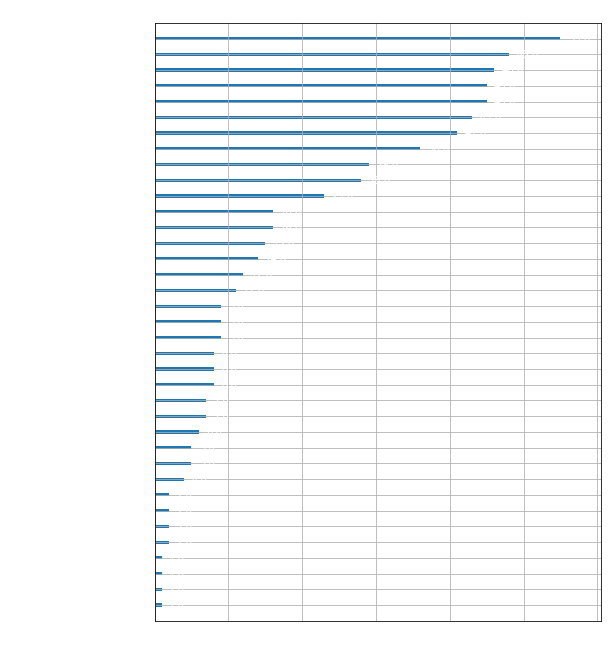

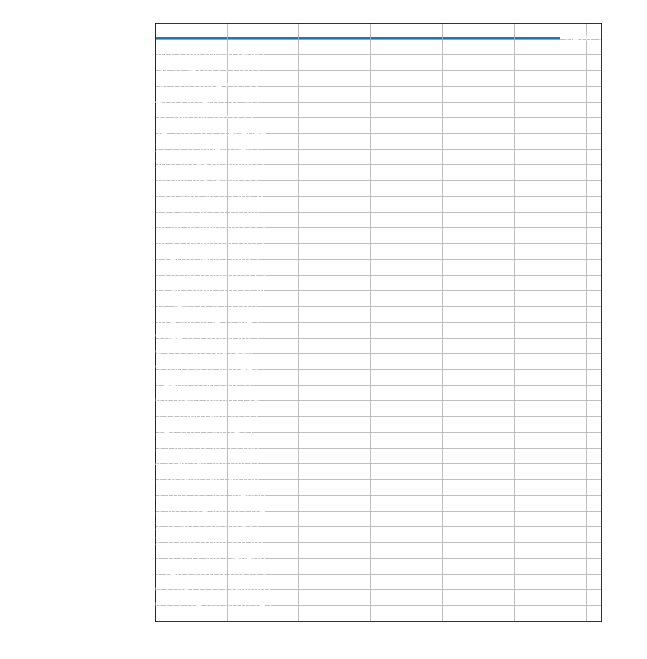

In [90]:
fig, ax = plt.subplots(figsize=(8,11))
xgb.plot_importance(gbm, ax=ax)
fig,ax2 = plt.subplots(figsize=(8,11))
xgb.plot_importance(gbm, importance_type='gain', ax=ax2)



In [91]:
gbm.get_booster().get_score(importance_type='weight')

{'Unnamed:0': 55.0,
 'Protocol': 1.0,
 'FlowDuration': 16.0,
 'TotalFwdPackets': 16.0,
 'TotalBackwardPackets': 7.0,
 'TotalLengthofFwdPackets': 48.0,
 'TotalLengthofBwdPackets': 2.0,
 'FwdPacketLengthMax': 1.0,
 'FwdPacketLengthMin': 8.0,
 'FwdPacketLengthMean': 6.0,
 'FwdPacketLengthStd': 9.0,
 'FlowBytes/s': 41.0,
 'FlowPackets/s': 14.0,
 'FlowIATMean': 2.0,
 'FwdIATTotal': 12.0,
 'FwdIATMean': 8.0,
 'FwdIATMin': 5.0,
 'BwdIATTotal': 2.0,
 'BwdIATMean': 43.0,
 'FwdPSHFlags': 11.0,
 'FwdHeaderLength': 9.0,
 'BwdHeaderLength': 2.0,
 'FwdPackets/s': 7.0,
 'BwdPackets/s': 36.0,
 'MinPacketLength': 45.0,
 'MaxPacketLength': 4.0,
 'PacketLengthMean': 1.0,
 'PacketLengthStd': 8.0,
 'SYNFlagCount': 46.0,
 'ACKFlagCount': 5.0,
 'URGFlagCount': 15.0,
 'CWEFlagCount': 28.0,
 'Init_Win_bytes_forward': 29.0,
 'Init_Win_bytes_backward': 1.0,
 'act_data_pkt_fwd': 9.0,
 'min_seg_size_forward': 45.0,
 'Inbound': 23.0}

In [92]:
gbm.get_booster().get_score(importance_type='gain')

{'Unnamed:0': 20.038799285888672,
 'Protocol': 3.3613924980163574,
 'FlowDuration': 13.016632080078125,
 'TotalFwdPackets': 9.844315528869629,
 'TotalBackwardPackets': 12.942246437072754,
 'TotalLengthofFwdPackets': 21.27313804626465,
 'TotalLengthofBwdPackets': 0.21732431650161743,
 'FwdPacketLengthMax': 2.3176651000976562,
 'FwdPacketLengthMin': 3.5187911987304688,
 'FwdPacketLengthMean': 14.277606010437012,
 'FwdPacketLengthStd': 10.45069694519043,
 'FlowBytes/s': 2.325611114501953,
 'FlowPackets/s': 15.79879093170166,
 'FlowIATMean': 5.727060794830322,
 'FwdIATTotal': 9.188996315002441,
 'FwdIATMean': 27.1641845703125,
 'FwdIATMin': 0.21897277235984802,
 'BwdIATTotal': 105.11441040039062,
 'BwdIATMean': 5.356899738311768,
 'FwdPSHFlags': 3.765984296798706,
 'FwdHeaderLength': 9.53773021697998,
 'BwdHeaderLength': 24.378257751464844,
 'FwdPackets/s': 15.898673057556152,
 'BwdPackets/s': 46.69987487792969,
 'MinPacketLength': 56420.3984375,
 'MaxPacketLength': 1.2463507652282715,
 'P

In [93]:
gbm.best_ntree_limit

25

In [94]:
gbm2 = xgb.XGBClassifier(
                        n_estimators=100000,
                        max_depth=9,
                        objective="binary:logistic",
                        learning_rate=.001,
                        subsample=.5,
                        scale_pos_weight=99,
                        min_child_weight=1,
                        colsample_bytree=1,
                        tree_method='gpu_hist',
                        use_label_encoder=False,
                        )

In [95]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=10)

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=10)

In [97]:
eval_set=[(X_train,y_train),(X_val,y_val)] 
fit_model = gbm2.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True 
                   )

[0]	validation_0-auc:0.99998	validation_1-auc:0.99998
[1]	validation_0-auc:0.99998	validation_1-auc:0.99998
[2]	validation_0-auc:0.99998	validation_1-auc:0.99998
[3]	validation_0-auc:0.99998	validation_1-auc:0.99998
[4]	validation_0-auc:0.99998	validation_1-auc:0.99998
[5]	validation_0-auc:1.00000	validation_1-auc:1.00000
[6]	validation_0-auc:1.00000	validation_1-auc:1.00000
[7]	validation_0-auc:1.00000	validation_1-auc:1.00000
[8]	validation_0-auc:1.00000	validation_1-auc:1.00000
[9]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10]	validation_0-auc:1.00000	validation_1-auc:1.00000
[11]	validation_0-auc:1.00000	validation_1-auc:1.00000
[12]	validation_0-auc:1.00000	validation_1-auc:1.00000
[13]	validation_0-auc:1.00000	validation_1-auc:1.00000
[14]	validation_0-auc:1.00000	validation_1-auc:1.00000
[15]	validation_0-auc:1.00000	validation_1-auc:1.00000
[16]	validation_0-auc:1.00000	validation_1-auc:1.00000
[17]	validation_0-auc:1.00000	validation_1-auc:1.00000
[18]	validation_0-au

In [98]:
gbm2.best_ntree_limit

26

In [99]:
y_val_preds = gbm2.predict(X_val, iteration_range=(1,26))
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9692307692307692, Recall: 0.987460815047022, F2 Score: 0.9837601499063084


In [100]:
gbm2_confusion = confusion_matrix(y_val, y_val_preds)

In [101]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in gbm2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in gbm2_confusion.flatten()/np.sum(gbm2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

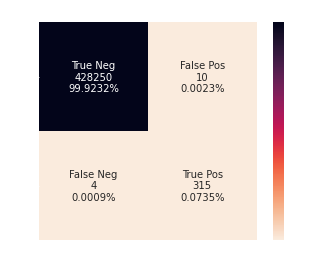

In [102]:
sns.heatmap(gbm2_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('XGBoost2 Confusion Matrix');

In [103]:
model_names = ["lr2", "rf", "imb_rf3", "gbm"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [104]:
voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='hard',
                                    n_jobs=-1)

In [105]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=11)

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=11)

In [107]:
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('lr2',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000000, n_jobs=-1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=3)),
                             ('imb_rf3',
                              BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                             n_estimators=1000,
                                                             n_jobs=-1,
                                                             random_state=8)),
                             ('gbm',
                              XGBClassifier(base_score=0.5, booster='gb...
                                            interaction_constraints='',
              

In [108]:
y_val_preds = voting_classifier.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9937304075235109, Recall: 0.9937304075235109, F2 Score: 0.9937304075235108


In [109]:
voting_classifier_confusion = confusion_matrix(y_val, y_val_preds)

In [110]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in voting_classifier_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in voting_classifier_confusion.flatten()/np.sum(voting_classifier_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

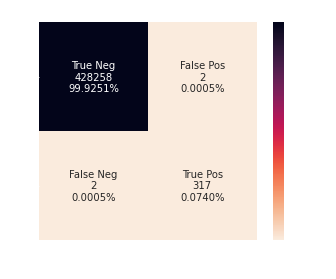

In [111]:
sns.heatmap(voting_classifier_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Voting Classifier Ensemble Confusion Matrix');

In [112]:
soft_voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='soft',
                                    n_jobs=-1)

In [113]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=12)

In [114]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=12)

In [115]:
soft_voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('lr2',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000000, n_jobs=-1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=3)),
                             ('imb_rf3',
                              BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                             n_estimators=1000,
                                                             n_jobs=-1,
                                                             random_state=8)),
                             ('gbm',
                              XGBClassifier(base_score=0.5, booster='gb...
                                            learning_rate=0.1, max_delta_step=0,
     

In [116]:
y_val_preds = soft_voting_classifier.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.8836565096952909, Recall: 1.0, F2 Score: 0.9743433109346364


In [117]:
soft_voting_classifier_confusion = confusion_matrix(y_val, y_val_preds)

In [118]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in soft_voting_classifier_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in soft_voting_classifier_confusion.flatten()/np.sum(soft_voting_classifier_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

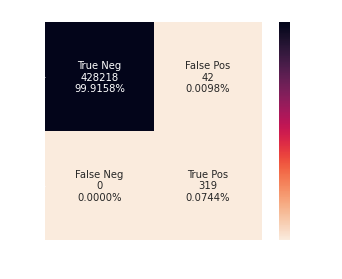

In [119]:
sns.heatmap(soft_voting_classifier_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Soft Voting Classifier Ensemble Confusion Matrix');

In [120]:
stacked = StackingClassifier(estimators=model_list, n_jobs=-1)

In [121]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=13)

In [122]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=13)

In [123]:
with joblib.parallel_backend("dask"):
    stacked.fit(X_train, y_train)

In [124]:
y_val_preds = stacked.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 1.0, Recall: 1.0, F2 Score: 1.0


In [125]:
stacked_voting_confusion = confusion_matrix(y_val, y_val_preds)

In [126]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in stacked_voting_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in stacked_voting_confusion.flatten()/np.sum(stacked_voting_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

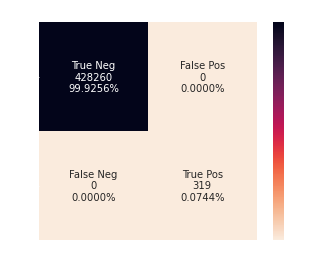

In [127]:
sns.heatmap(stacked_voting_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Stacked Classifier Ensemble Confusion Matrix');

In [128]:
y_test_preds = stacked.predict(X_test)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_test, y_test_preds), recall_score(y_test, y_test_preds), fbeta_score(y_test, y_test_preds, beta=2.0)))

Precision: 1.0, Recall: 0.9968553459119497, F2 Score: 0.9974826935179357


In [129]:
stacked_voting_confusion_test = confusion_matrix(y_test, y_test_preds)

In [130]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in stacked_voting_confusion_test.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in stacked_voting_confusion_test.flatten()/np.sum(stacked_voting_confusion_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

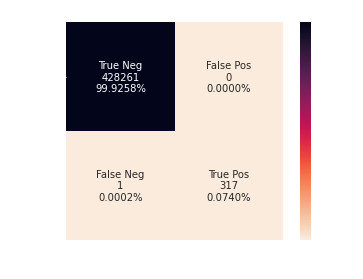

In [131]:
sns.heatmap(stacked_voting_confusion_test,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Stacked Classifier Ensemble Confusion Matrix - Test Set');

Logistic Regression Model best F Beta2 score 0.000 at prob decision threshold >= 0.010
Logistic Regression Model best recall score 0.000 at prob decision threshold >= 0.010
Logistic Regression Model best precision score 0.000 at prob decision threshold >= 0.010


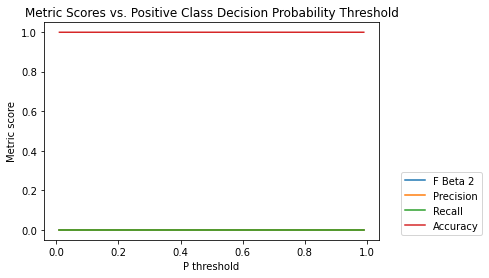

In [153]:
thresh_ps = np.linspace(0.01,0.99,101)
model_test_probs = stacked.predict_proba(X_test)[:,1]

fbeta_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_test_probs >= p
    fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=2))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, fbeta_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F Beta 2','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_fbeta_score = np.max(fbeta_scores) 
best_thresh_p_fbeta = thresh_ps[np.argmax(fbeta_scores)]
best_recall_score = np.max(rec_scores)
best_thresh_p_rec = thresh_ps[np.argmax(rec_scores)]
best_prec_score = np.max(prec_scores)
best_thresh_p_prec = thresh_ps[np.argmax(prec_scores)]

print('Logistic Regression Model best F Beta2 score %.3f at prob decision threshold >= %.3f' 
      % (best_fbeta_score, best_thresh_p_fbeta))
print('Logistic Regression Model best recall score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_rec))
print('Logistic Regression Model best precision score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_prec))

In [143]:
test_preds = stacked.predict(X_test)

In [144]:
precision, recall, _ = precision_recall_curve(y_test, test_preds)

In [145]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)

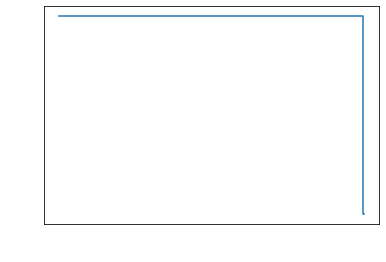

In [146]:
disp.plot()

In [149]:
from sklearn.metrics import RocCurveDisplay

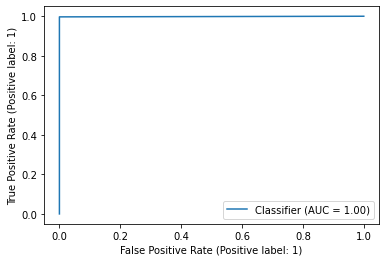

In [152]:
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
RocCurveDisplay.from_predictions(y_test, test_preds);